In [31]:
from classifier import CustomDecisionTreeClassifier
from regressor import CustomDecisionTreeRegressor
from gradient_boosting import MulticlassGB

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_iris
from sklearn import datasets


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

# Дерево решений: Классификация

## Данные

In [2]:
iris = load_iris()

df = pd.DataFrame(iris['data'], columns=iris.feature_names)
df['target'] = iris['target']
df['target_names'] = df['target'].replace({i: cls for i, cls in enumerate(iris.target_names)})

X = iris['data']
y = iris['target'].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

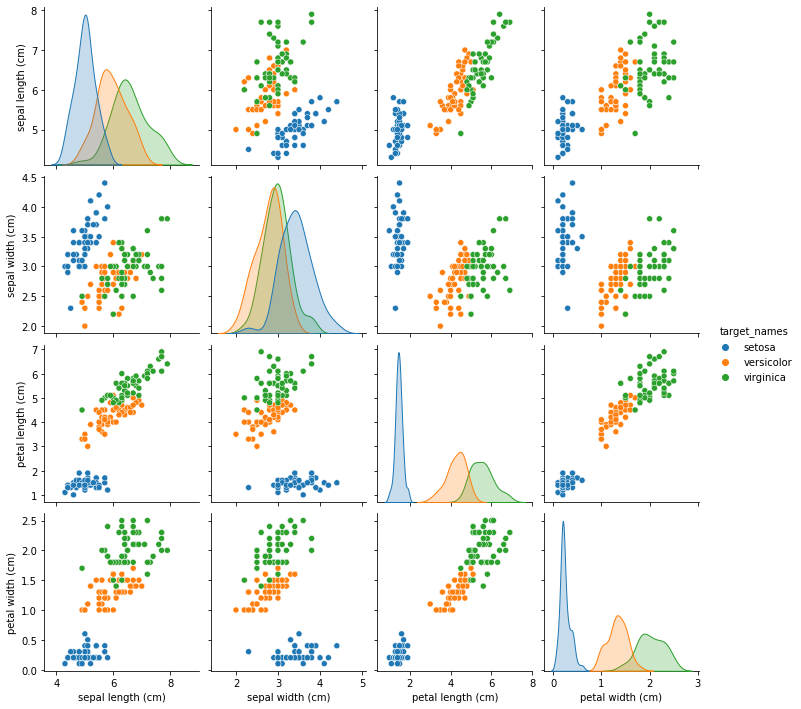

In [3]:
sns.pairplot(df.drop(columns=['target']), hue='target_names')

## Обучение + сравнение с sklearn

In [4]:
model = CustomDecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion_name='gini')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=4, criterion='gini')
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [5]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



In [6]:
y_pred_sklearn = model_sklearn.predict(X_test)

print(classification_report(y_test, y_pred_sklearn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.73      0.89      0.80         9
           2       0.89      0.73      0.80        11

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



### Поэлементное сравнение

In [7]:
accuracy_score(y_pred_sklearn, np.squeeze(y_pred))

1.0

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем два из четырех исходных признаков, например, petal lenght и sepal length, и обучим классификатор на них

In [8]:
X = df[['sepal width (cm)', 'sepal length (cm)']].values
y = df[['target']].values

In [9]:
# Функция для отрисовки разделяющих областей классов
def draw_contour(ax, model, colors):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.arange(model.n_classes + 1)-0.5, 
        colors=colors, 
        alpha=0.5
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

colors = ['blue', 'orange', 'green']

Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### gini impurity

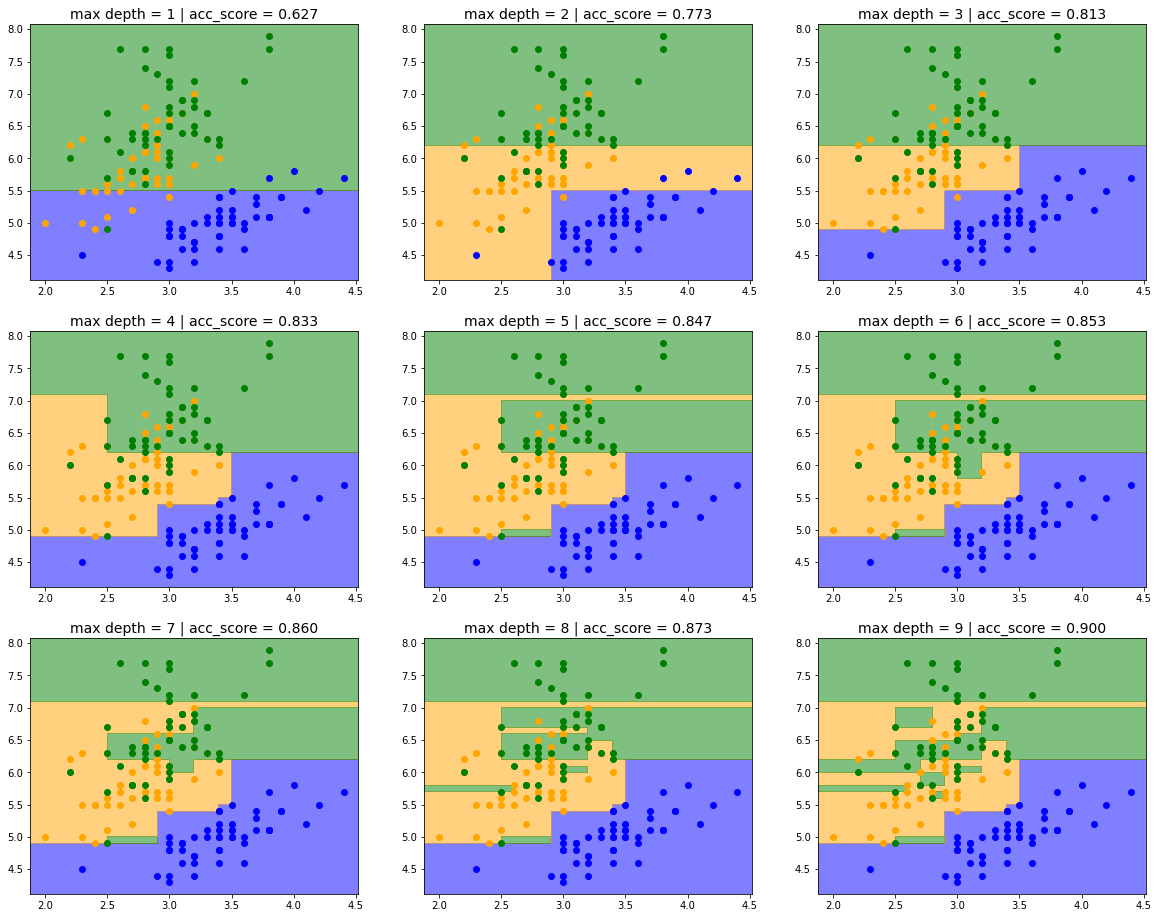

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'max depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

#### entropy

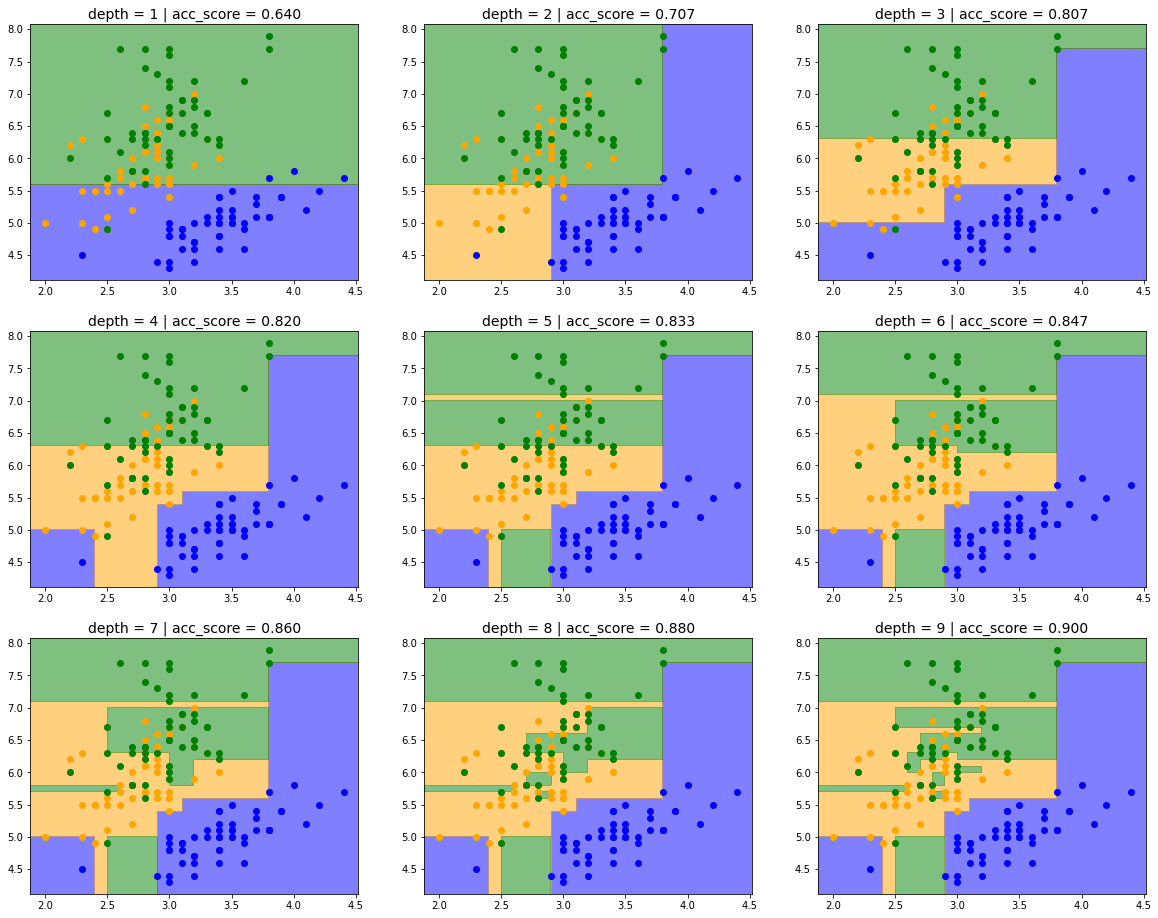

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='entropy')
    model.fit(X, y)
    a = accuracy_score(y, model.predict(X))
    
    
    i, j = k // 3, k % 3
    for m in range(model.n_classes):
        ax[i, j].plot(*X[np.squeeze(y) == m].T, 'o', color=colors[m])
        ax[i, j].set_title(f'depth = {k+1} | acc_score = {a:.3f}', fontsize=14)
        
    draw_contour(ax[i, j], model, colors)    

# Эксперимент с глубиной дерева

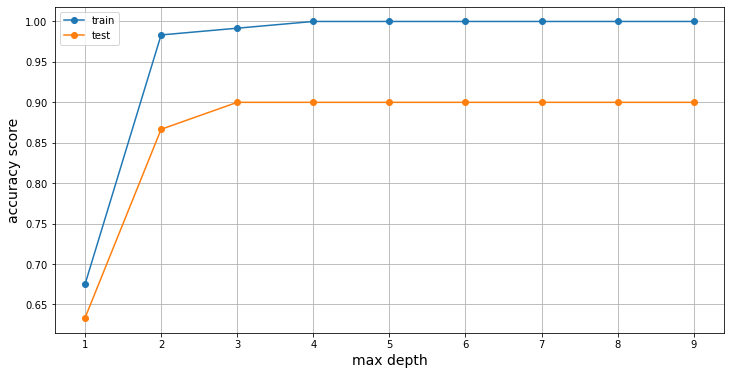

In [12]:
results_train = []
results_test = []

for k in range(9):
    model = CustomDecisionTreeClassifier(max_depth=k+1, criterion_name='gini')
    model.fit(X_train, y_train)
    
    a = accuracy_score(y_train, model.predict(X_train))
    results_train.append([k+1, a])
    
    a = accuracy_score(y_test, model.predict(X_test))
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('accuracy score', fontsize=14)
ax.legend()
ax.grid()

# Дерево решений: Регрессия

## Данные

In [13]:
df = pd.read_csv('data/day.csv')
df = df.drop(columns=['instant', 'dteday'])
display(df.head())

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


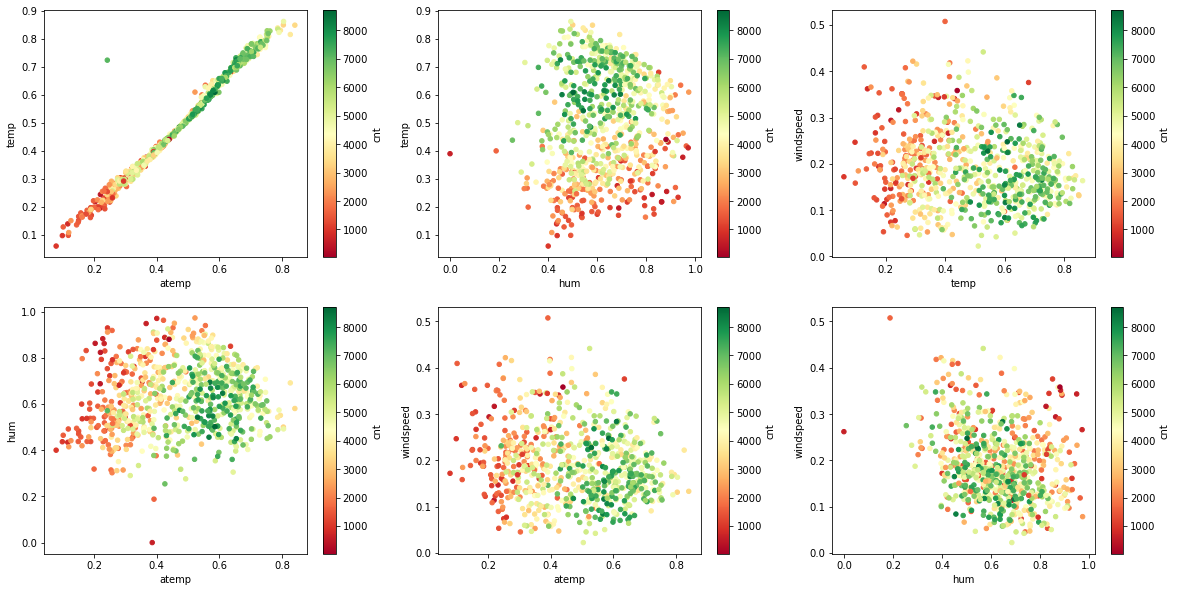

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
feature_pairs = [
    ['atemp', 'temp'],
    ['hum', 'temp'],
    ['temp', 'windspeed'],
    ['atemp', 'hum'],
    ['atemp', 'windspeed'],
    ['hum', 'windspeed']
]
for k, pair in enumerate(feature_pairs):
    i, j = k // 3, k % 3
    df.plot(kind='scatter', x=pair[0], y=pair[1], c='cnt', cmap='RdYlGn', ax=ax[i, j])

In [15]:
features = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
    'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'
]

X = df[features].values
y = df[['cnt']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Обучение + сравнение с sklearn

In [16]:
model = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, criterion_name='variance')
model.fit(X_train, y_train)

model_sklearn = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
model_sklearn.fit(X_train, y_train)

pass

### Сравнение метрик 

In [17]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

369.88286976538615

In [18]:
y_pred_sklearn = model_sklearn.predict(X_test)
mean_squared_error(y_test, y_pred_sklearn)**0.5

364.1061594471585

### Поэлементное сравнение

In [19]:
mean_squared_error(y_pred_sklearn, np.squeeze(y_pred))**0.5

99.30850397734825

## Визуализация решающий правил

Для визуализации решающих правил дерева возьмем какие нибудь два признака, например, temp и hum, и обучим модель на них

In [20]:
X = df[['temp', 'hum']].values
y = df[['cnt']].values

In [21]:
# Функция для отрисовки разделяющих линий
def draw_levels(ax, model):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    num = 501
    x = np.linspace(*xlim, num)
    y = np.linspace(*ylim, num)
    X = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    Y = model.predict(X)
    con = ax.contourf(
        x, y, np.squeeze(Y).reshape(num, num).T, 
        levels=np.linspace(Y.min(), Y.max()), 
        alpha=0.5,
        cmap = 'RdYlGn'
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


Визуализация решающих правил в зависимости от максимальной глубины дерева и критерия разбиения

#### variance

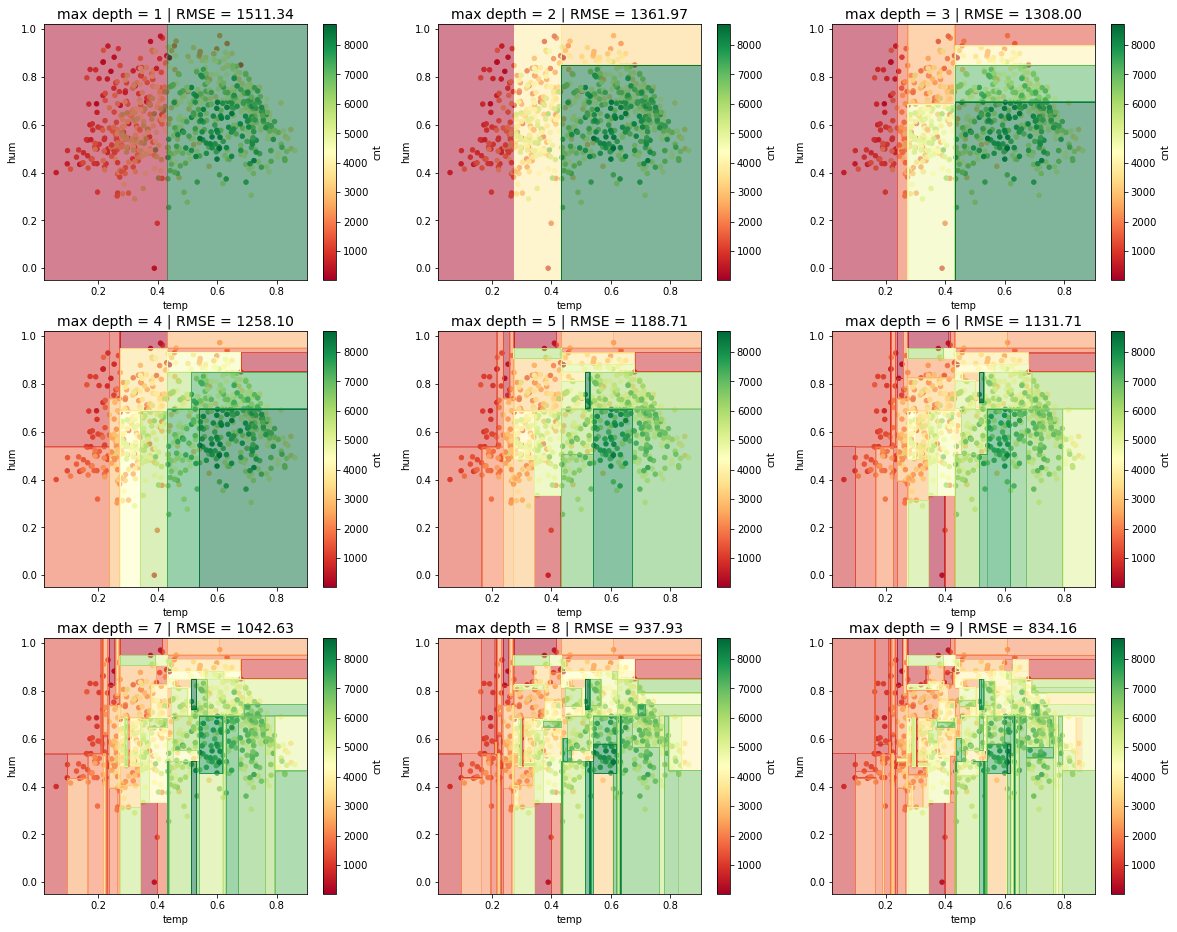

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

#### mad_median

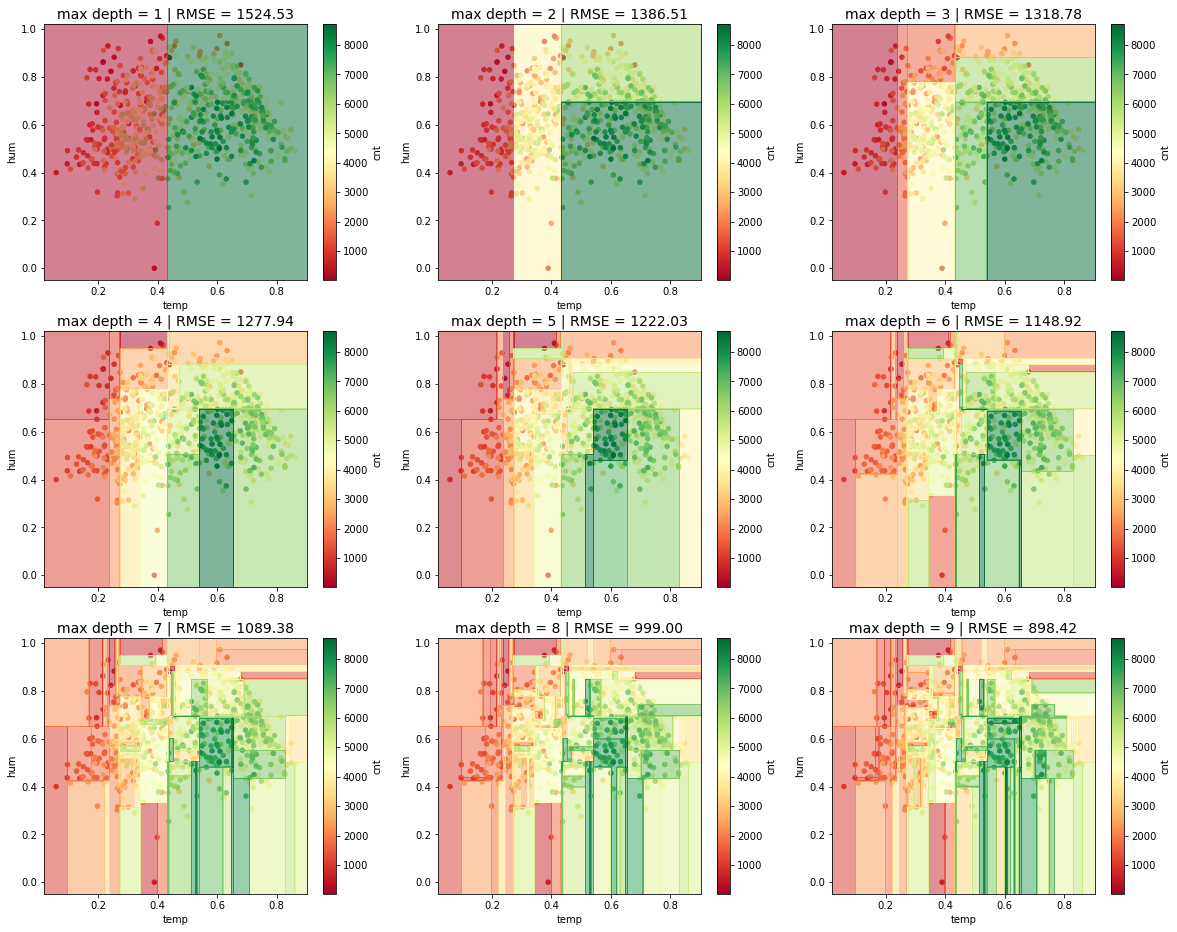

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for k in range(9):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='mad_median')
    model.fit(X, y)
    a = mean_squared_error(y, model.predict(X))**0.5
    
    
    i, j = k // 3, k % 3
    ax[i, j].set_title(f'max depth = {k+1} | RMSE = {a:.2f}', fontsize=14)
    df.plot(kind='scatter', x='temp', y='hum', c='cnt', cmap='RdYlGn', ax=ax[i, j])    
    
    draw_levels(ax[i, j], model)    

# Эксперимент с глубиной дерева

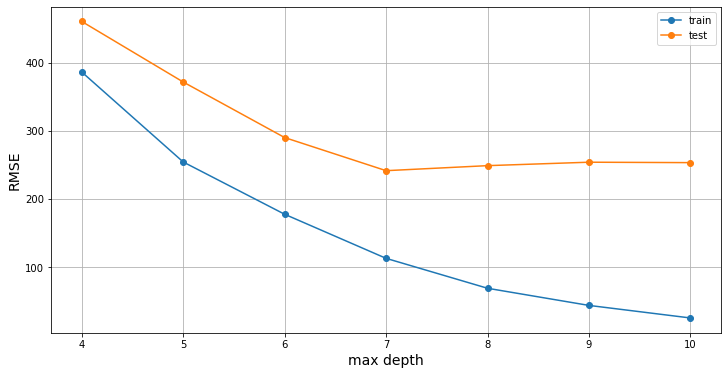

In [24]:
results_train = []
results_test = []

for k in range(3, 10):
    model = CustomDecisionTreeRegressor(max_depth=k+1, criterion_name='variance')
    model.fit(X_train, y_train)
    
    a = mean_squared_error(y_train, model.predict(X_train))**0.5
    results_train.append([k+1, a])
    
    a = mean_squared_error(y_test, model.predict(X_test))**0.5
    results_test.append([k+1, a])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(*np.array(results_train).T, marker='o', label='train')
ax.plot(*np.array(results_test).T, marker='o', label='test')
ax.set_xlabel('max depth', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend()
ax.grid()

# Градиентный бустинг на деревьях: Классификация

In [32]:
# Параметрами с которыми мы будем обучать деревья
TREE_PARAMS_DICT = {'max_depth': 2,
                    'learning_rate' : 0.05,
                   "n_estimators" : 200}
N_CLASSES = 3
N_SAMPLES = 2000

Подгрузим данные.

In [33]:
data, target = datasets.make_classification(n_samples=N_SAMPLES, n_classes=N_CLASSES, n_clusters_per_class=1)

In [34]:
gbr = GradientBoostingClassifier(**TREE_PARAMS_DICT)

Качество реализации GBR из sklearn.

In [35]:
np.mean(cross_val_score(gbr, data, target, cv=3, scoring='accuracy'))

0.8970049509779644

Инициализируем нашу версию градиентного бустинга

In [36]:
algo = MulticlassGB(**TREE_PARAMS_DICT)

Качество нашей реализации

In [37]:
np.mean(cross_val_score(algo, data, target, cv=3, scoring='accuracy'))

0.8960024492258376

# Сравнение бустингов

In [54]:
data = pd.read_csv("./data/horse.csv")
data = data.fillna(-9999999999)
display(data)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,3.850000e+01,66.0,28.0,cool,reduced,-9999999999,more_3_sec,...,45.0,8.400000e+00,-9999999999,-1.000000e+10,died,no,11300,0,0,no
1,yes,adult,534817,3.920000e+01,88.0,20.0,-9999999999,-9999999999,pale_cyanotic,less_3_sec,...,50.0,8.500000e+01,cloudy,2.000000e+00,euthanized,no,2208,0,0,no
2,no,adult,530334,3.830000e+01,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.700000e+00,-9999999999,-1.000000e+10,lived,no,0,0,0,yes
3,yes,young,5290409,3.910000e+01,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.200000e+00,serosanguious,5.300000e+00,died,yes,2208,0,0,yes
4,no,adult,530255,3.730000e+01,104.0,35.0,-9999999999,-9999999999,dark_cyanotic,more_3_sec,...,74.0,7.400000e+00,-9999999999,-1.000000e+10,died,no,4300,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,-1.000000e+10,120.0,70.0,cold,-9999999999,pale_cyanotic,more_3_sec,...,55.0,6.500000e+01,-9999999999,-1.000000e+10,euthanized,no,3205,0,0,no
295,no,adult,527702,3.720000e+01,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,44.0,-1.000000e+10,serosanguious,3.300000e+00,euthanized,yes,2208,0,0,yes
296,yes,adult,529386,3.750000e+01,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,60.0,6.800000e+00,-9999999999,-1.000000e+10,died,yes,3205,0,0,no
297,yes,adult,530612,3.650000e+01,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,50.0,6.000000e+00,serosanguious,3.400000e+00,lived,yes,2208,0,0,yes


In [55]:
data["SAMPLE"] = "TRAIN"
data.loc[200:250, "SAMPLE"] = "VALID"
data.loc[250:, "SAMPLE"] = "TEST"
data.SAMPLE.value_counts()

TRAIN    200
VALID     50
TEST      49
Name: SAMPLE, dtype: int64

In [56]:
CAT_COLS =['surgery','age','temp_of_extremities','peripheral_pulse','mucous_membrane',
          'capillary_refill_time','pain','peristalsis','abdominal_distention','nasogastric_tube',
          'nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance','surgical_lesion','cp_data']
FEATURES = list(set(data.columns) - set(['outcome', 'SAMPLE']))
TARGET = "outcome"
SAMPLE = 'SAMPLE'
TRAIN_MASK = data.SAMPLE == "TRAIN"
VALID_MASK = data.SAMPLE == "VALID"
TEST_MASK = data.SAMPLE == "TEST"

In [57]:
data.loc[:, CAT_COLS + [TARGET]] = data.loc[:, CAT_COLS + [TARGET]].astype(str)
data, label_encoders = feature_encoding(data, CAT_COLS + [TARGET])

In [58]:
data.dtypes

surgery                    int32
age                        int32
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities        int32
peripheral_pulse           int32
mucous_membrane            int32
capillary_refill_time      int32
pain                       int32
peristalsis                int32
abdominal_distention       int32
nasogastric_tube           int32
nasogastric_reflux         int32
nasogastric_reflux_ph    float64
rectal_exam_feces          int32
abdomen                    int32
packed_cell_volume       float64
total_protein            float64
abdomo_appearance          int32
abdomo_protein           float64
outcome                    int32
surgical_lesion            int32
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                    int32
SAMPLE                    object
dtype: object

## MulticlassGB

In [59]:
gbr = MulticlassGB(max_depth=100000, learning_rate=0.1, n_estimators=100)

In [60]:
gbr.fit(data.loc[TRAIN_MASK, FEATURES], data.loc[TRAIN_MASK, TARGET])

MulticlassGB(learning_rate=0.1, max_depth=100000, n_estimators=100)

In [62]:
y_pred = gbr.predict(data.loc[:, FEATURES])

In [64]:
print('MulticlassGB Model train accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TRAIN_MASK, TARGET], y_pred[TRAIN_MASK])))
print('MulticlassGB Model valid accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[VALID_MASK, TARGET], y_pred[VALID_MASK])))
print('MulticlassGB Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TEST_MASK, TARGET], y_pred[TEST_MASK])))

MulticlassGB Model train accuracy score: 1.0000
MulticlassGB Model valid accuracy score: 0.6400
MulticlassGB Model test accuracy score: 0.5102


## LightGBM

### Преимущества LightGBM:
1.) Повершинное построение деревьев — ускорение за счёт структуры.
    
        Мы строим деревья не слой за слоем, а выбираем лист в котором уменьшается наш loss сильнее, чем в остальных. Этот лист дальше разбиваем, растим, и получается, что у нас деревья могут быть несимметричные и глубокие.

2.) GOSS (Gradient-based One-Side Sampling). Используем меньше наблюдений.

    Обращаем бОльшее внимание на наблюдения с бОльшим градиентом.

3.) EFB (Exclusive Feature Bunding). Используем меньше признаков.

    Вместо k-признаков, построить p-связок (p<=k) и использовать только их при нахождении оптимальной точки расщепления при построении деревьев. Причём построим эти связки только один раз — в самом начале.
    
Подробнее: https://habr.com/ru/companies/tochka/articles/751012/

In [219]:
!pip install lightgbm

In [65]:
import lightgbm as lgb

In [66]:
clf = lgb.LGBMClassifier(verbose=-1)
clf.fit(data.loc[TRAIN_MASK, FEATURES], data.loc[TRAIN_MASK, TARGET])

LGBMClassifier(verbose=-1)

In [68]:
y_pred = clf.predict(data.loc[:, FEATURES])

In [69]:
print('LightGBM Model train accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TRAIN_MASK, TARGET], y_pred[TRAIN_MASK])))
print('LightGBM Model valid accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[VALID_MASK, TARGET], y_pred[VALID_MASK])))
print('LightGBM Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TEST_MASK, TARGET], y_pred[TEST_MASK])))

LightGBM Model train accuracy score: 1.0000
LightGBM Model valid accuracy score: 0.5800
LightGBM Model test accuracy score: 0.5918


## Catboost

### Преимущества Catboost:

1.) Симметричные решающие таблицы

    В каждом узле на одном и том же уровне дерева используется одна и та же точка расщепления.

2.) Обработка категориальных признаков

    Реализован модифицированный подход к mean target encoding.

3.) Динамический бустинг

4.) Обучение на GPU
    
Подробнее: https://habr.com/ru/companies/tochka/articles/751012/

In [226]:
!pip install catboost

In [70]:
from catboost import Pool, CatBoostClassifier

In [71]:

train_dataset = Pool(data=data.loc[TRAIN_MASK, FEATURES],
                     label=data.loc[TRAIN_MASK, TARGET],
                     cat_features=CAT_COLS)
valid_dataset = Pool(data=data.loc[VALID_MASK, FEATURES],
                    label=data.loc[VALID_MASK, TARGET],
                    cat_features=CAT_COLS)
eval_dataset = Pool(data=data.loc[TEST_MASK, FEATURES],
                    label=data.loc[TEST_MASK, TARGET],
                    cat_features=CAT_COLS)

In [72]:
model = CatBoostClassifier(loss_function='MultiClass', verbose=False)
model.fit(train_dataset)

In [73]:
y_pred_train = model.predict(train_dataset)
y_pred_valid = model.predict(valid_dataset)
y_pred_test = model.predict(eval_dataset)

In [75]:
print('Catboost Model train accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TRAIN_MASK, TARGET], y_pred_train)))

Catboost Model train accuracy score: 0.9500


In [76]:
print('Catboost Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[VALID_MASK, TARGET], y_pred_valid)))

Catboost Model test accuracy score: 0.6600


In [77]:
print('Catboost Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TEST_MASK, TARGET], y_pred_test)))

Catboost Model test accuracy score: 0.6327


## XGBoost

   Основной ценностью библиотеки XGBoost является эффективная программная реализация. За счет разных оптимизаций, таких как эффективная работа с пропущенными значениями, поиск порога только среди персентилей, оптимизация работа с кэшем и распределенное обучение, достигается выигрыш в десятки или даже сотни раз по сравнению с наивной реализацией.

In [234]:
!pip install xgboost

In [78]:
from xgboost import XGBClassifier

In [79]:
model = XGBClassifier()
model.fit(data.loc[TRAIN_MASK, FEATURES], data.loc[TRAIN_MASK, TARGET])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [80]:
y_pred = model.predict(data.loc[:, FEATURES])

In [81]:
print('XGBoost Model train accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TRAIN_MASK, TARGET], y_pred[TRAIN_MASK])))
print('XGBoost Model valid accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[VALID_MASK, TARGET], y_pred[VALID_MASK])))
print('XGBoost Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TEST_MASK, TARGET], y_pred[TEST_MASK])))

XGBoost Model train accuracy score: 1.0000
XGBoost Model valid accuracy score: 0.6200
XGBoost Model test accuracy score: 0.5510


## Подбор гиперпараметров на Catboost с помощью optuna

Гиперпараметры — это характеристики модели, которые фиксируются до начала обучения (например - глубина решающего дерева, значение силы регуляризации в линейной модели, learning rate для градиентного спуска). Гиперпараметры, в отличие от параметров задаются разработчиком модели перед ее обучением, в свою очередь параметры модели настраиваются в процессе обучения модели на данных.

Optuna — это фреймворк для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:

    1.) Настраиваемое пространство поиска гиперпараметров. Разработчик может самостоятельно задать пространство для поиска гиперпараметров, используя базовый синтаксис Python (циклы, условия).

    2.) Алгоритмы SoTA для выбора гиперпараметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный.

    3.) Легкость расспаралеливания процесса поиска гиперпараметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

Подробнее: https://habr.com/ru/articles/704432/

In [241]:
!pip install optuna

In [82]:
import optuna

In [84]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(data.loc[TRAIN_MASK, FEATURES], data.loc[TRAIN_MASK, TARGET])
    y_pred = model.predict(data.loc[VALID_MASK, FEATURES])
    return accuracy_score(data.loc[VALID_MASK, TARGET], y_pred)

In [85]:
study = optuna.create_study(study_name="catboost", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-10-07 19:16:30,382] A new study created in memory with name: catboost
[I 2023-10-07 19:16:30,527] Trial 0 finished with value: 0.64 and parameters: {'iterations': 136, 'learning_rate': 0.07250533341215637, 'depth': 5, 'l2_leaf_reg': 0.6499508204417045, 'bootstrap_type': 'Bayesian', 'random_strength': 2.1406823631574306e-08, 'bagging_temperature': 6.264748962154789, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 0 with value: 0.64.
[I 2023-10-07 19:16:34,581] Trial 1 finished with value: 0.64 and parameters: {'iterations': 871, 'learning_rate': 0.01067380347687244, 'depth': 8, 'l2_leaf_reg': 19.494670661278764, 'bootstrap_type': 'Bayesian', 'random_strength': 0.23801230024652764, 'bagging_temperature': 5.112091930388345, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 0 with value: 0.64.
[I 2023-10-07 19:16:35,906] Trial 2 finished with value: 0.68 and parameters: {'iterations': 279, 'learning_rate': 0.07145667339593091, 'depth': 8, 'l2_leaf_reg': 22.771838150280413, 'boo

[I 2023-10-07 19:17:52,051] Trial 22 finished with value: 0.68 and parameters: {'iterations': 452, 'learning_rate': 0.02626229704284125, 'depth': 9, 'l2_leaf_reg': 11.324596418512773, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1967385662200017e-05, 'bagging_temperature': 6.253899666201169, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 3 with value: 0.7.
[I 2023-10-07 19:17:53,070] Trial 23 finished with value: 0.66 and parameters: {'iterations': 210, 'learning_rate': 0.041239999299304816, 'depth': 8, 'l2_leaf_reg': 0.6711043237520807, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0001520693363760516, 'bagging_temperature': 9.184955454467254, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 3 with value: 0.7.
[I 2023-10-07 19:17:58,982] Trial 24 finished with value: 0.66 and parameters: {'iterations': 326, 'learning_rate': 0.060552219535050716, 'depth': 10, 'l2_leaf_reg': 15.310845199494906, 'bootstrap_type': 'Bayesian', 'random_strength': 5.1135287884292645e-06, 'baggin

[I 2023-10-07 19:19:45,266] Trial 45 finished with value: 0.66 and parameters: {'iterations': 729, 'learning_rate': 0.0196125830077725, 'depth': 9, 'l2_leaf_reg': 17.71468181609401, 'bootstrap_type': 'Bayesian', 'random_strength': 6.829384967764549e-07, 'bagging_temperature': 8.488486326547601, 'od_type': 'Iter', 'od_wait': 27}. Best is trial 3 with value: 0.7.
[I 2023-10-07 19:19:53,441] Trial 46 finished with value: 0.66 and parameters: {'iterations': 432, 'learning_rate': 0.015388924247963103, 'depth': 10, 'l2_leaf_reg': 36.51837148753498, 'bootstrap_type': 'Bayesian', 'random_strength': 1.628725430859861e-05, 'bagging_temperature': 7.393924482074754, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 3 with value: 0.7.
[I 2023-10-07 19:19:55,954] Trial 47 finished with value: 0.62 and parameters: {'iterations': 526, 'learning_rate': 0.03221808964565725, 'depth': 8, 'l2_leaf_reg': 0.3229747504351257, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0022205369044385748, 'bagging_temp

[I 2023-10-07 19:21:31,092] Trial 68 finished with value: 0.72 and parameters: {'iterations': 596, 'learning_rate': 0.012330410539138784, 'depth': 9, 'l2_leaf_reg': 0.2602306622482218, 'bootstrap_type': 'Bayesian', 'random_strength': 8.976513771695913e-08, 'bagging_temperature': 8.78728518130566, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 68 with value: 0.72.
[I 2023-10-07 19:21:33,970] Trial 69 finished with value: 0.64 and parameters: {'iterations': 620, 'learning_rate': 0.011992494086275899, 'depth': 8, 'l2_leaf_reg': 1.3235899217637908, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1268064300550819e-07, 'bagging_temperature': 8.756057028208662, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 68 with value: 0.72.
[I 2023-10-07 19:21:39,898] Trial 70 finished with value: 0.66 and parameters: {'iterations': 651, 'learning_rate': 0.022610357179969436, 'depth': 9, 'l2_leaf_reg': 0.10020966332151182, 'bootstrap_type': 'Bayesian', 'random_strength': 2.611556339494669e-08, 'bag

[I 2023-10-07 19:23:22,339] Trial 91 finished with value: 0.66 and parameters: {'iterations': 357, 'learning_rate': 0.03493761614430886, 'depth': 9, 'l2_leaf_reg': 21.666347006221102, 'bootstrap_type': 'Bayesian', 'random_strength': 1.251485659726664e-06, 'bagging_temperature': 7.889980027424046, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 68 with value: 0.72.
[I 2023-10-07 19:23:24,120] Trial 92 finished with value: 0.66 and parameters: {'iterations': 371, 'learning_rate': 0.04301629743084056, 'depth': 8, 'l2_leaf_reg': 9.352643450586436, 'bootstrap_type': 'Bayesian', 'random_strength': 3.768714581597917e-07, 'bagging_temperature': 8.286780459851336, 'od_type': 'Iter', 'od_wait': 18}. Best is trial 68 with value: 0.72.
[I 2023-10-07 19:23:27,769] Trial 93 finished with value: 0.7 and parameters: {'iterations': 385, 'learning_rate': 0.027685233808300343, 'depth': 9, 'l2_leaf_reg': 4.002857700648624, 'bootstrap_type': 'Bayesian', 'random_strength': 8.209198999268751e-07, 'bagging_t

In [86]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.72
  Params: 
    iterations: 596
    learning_rate: 0.012330410539138784
    depth: 9
    l2_leaf_reg: 0.2602306622482218
    bootstrap_type: Bayesian
    random_strength: 8.976513771695913e-08
    bagging_temperature: 8.78728518130566
    od_type: Iter
    od_wait: 23


In [87]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(data.loc[TRAIN_MASK, FEATURES], data.loc[TRAIN_MASK, TARGET])

y_pred = model.predict(data.loc[:, FEATURES])

In [88]:
print('Catboost Model train accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TRAIN_MASK, TARGET], y_pred[TRAIN_MASK])))
print('Catboost Model valid accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[VALID_MASK, TARGET], y_pred[VALID_MASK])))
print('Catboost Model test accuracy score: {0:0.4f}'.format(accuracy_score(data.loc[TEST_MASK, TARGET], y_pred[TEST_MASK])))

Catboost Model train accuracy score: 1.0000
Catboost Model valid accuracy score: 0.7200
Catboost Model test accuracy score: 0.5918


### Выводы:
    
    1.) Catboost хорошо работает "из коробки" (показал лучшие результаты с параметрами по умолчанию)
        P.S. Это не всегда так! Поэтому всегда стоит пробовать разные алгоритмы!
    
    2.) Подбор гиперпараметров позволил существенно улучшить качество на валидационной выборке, но на тестовой качество 
    снизилось. Следовательно, мы "переобучились" под валидацию в смысле подбора гиперпараметров. Надо быть внимательнее и не допускать этого.